# LangChain Fundamentals: Agents, Messages & Streaming

This notebook covers the core building blocks of LangChain 1.0:

1. **Building Agents** - The `create_agent()` API for building AI agents
2. **Messages** - The fundamental unit of context for LLM communication  
3. **Streaming** - Reducing latency by streaming responses

---

## Setup

First, let's install the required packages and set up our environment.

In [1]:
%pip install -qU langchain langchain-openai langchain-community langgraph

Error processing line 1 of /Users/greatmaster/miniconda3/envs/oreilly-langchain/lib/python3.12/site-packages/distutils-precedence.pth:

  Traceback (most recent call last):
    File "<frozen site>", line 206, in addpackage
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named '_distutils_hack'

Remainder of file ignored
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

---

# Part 1: Building Agents with `create_agent()`

In LangChain 1.0, the `create_agent()` function is the primary way to build AI agents. It provides a clean, declarative API that handles:

- Model selection and configuration
- Tool binding
- System prompts
- Runtime context (dependency injection)
- Middleware (like human-in-the-loop)

## 1.1 Your First Agent

Let's create a simple agent that can answer questions:

In [3]:
from langchain.agents import create_agent

# Create a simple agent with a system prompt
agent = create_agent(
    model="openai:gpt-4o-mini",
    system_prompt="You are a helpful assistant that explains concepts clearly and concisely."
)

In [4]:
# Invoke the agent with a question
result = agent.invoke({"messages": "What is LangChain?"})
print(result["messages"][-1].content)

LangChain is a framework designed to simplify the development of applications using large language models (LLMs). It provides a set of tools and components that help developers integrate LLMs into their applications more effectively. 

Key features of LangChain include:

1. **Modularity**: LangChain allows users to easily combine various components such as prompt templates, chains of operations, and memory to create more complex interactions with language models.

2. **Integrations**: The framework supports integration with various LLM providers (like OpenAI, Google, etc.) as well as other services, enabling a seamless connection to different data sources and APIs.

3. **Chain Operations**: It helps in creating chains of calls or operations where the output of one LLM can be fed into another or into other logic, allowing for more sophisticated workflows.

4. **Memory**: LangChain can manage and utilize memory, storing context or information across interactions, which can enhance dialog

## 1.2 Agent with Tools

Agents become powerful when they can use tools. Let's create a SQL agent that can query a database.

First, we'll set up a SQLite database and define a runtime context for dependency injection:

In [5]:
from langchain_community.utilities import SQLDatabase
from dataclasses import dataclass

# Load the Chinook sample database (music store data)
db = SQLDatabase.from_uri("sqlite:///./assets-resources/Chinook.db")

# Define runtime context for dependency injection
@dataclass
class RuntimeContext:
    db: SQLDatabase

In [6]:
from langchain_core.tools import tool
from langgraph.runtime import get_runtime

@tool
def execute_sql(query: str) -> str:
    """Execute a SQLite SELECT query and return results."""
    runtime = get_runtime(RuntimeContext)
    db = runtime.context.db
    
    try:
        return db.run(query)
    except Exception as e:
        return f"Error: {e}"

In [7]:
SYSTEM_PROMPT = """You are a careful SQLite analyst.

Rules:
- Think step-by-step.
- When you need data, call the tool `execute_sql` with ONE SELECT query.
- Read-only only; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE.
- Limit to 5 rows unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.
"""

sql_agent = create_agent(
    model="openai:gpt-4o-mini",
    tools=[execute_sql],
    system_prompt=SYSTEM_PROMPT,
    context_schema=RuntimeContext,
)

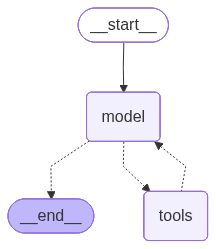

In [8]:
# Visualize the agent's ReAct loop
from IPython.display import Image, display

display(Image(sql_agent.get_graph(xray=True).draw_mermaid_png()))

In [9]:
# Run a query - the agent will discover the schema and answer
question = "Which table has the largest number of entries?"

for step in sql_agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which table has the largest number of entries?
================================== Ai Message ==================================

To determine which table has the largest number of entries, I need to first retrieve a list of all tables in the database. Then I can count the number of entries in each table. I'll start by querying the list of tables. 

Let's begin by executing a query to get the list of tables in the database.
Tool Calls:
  execute_sql (call_pDk8fWUG3SRTwgFoQHvmE7A3)
 Call ID: call_pDk8fWUG3SRTwgFoQHvmE7A3
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: execute_sql


================================== Ai Message ==================================

It seems that I wasn't able to retrieve the list of tables. Let me revise the SQL query and try again.
Tool Calls:
  execute_sql (call_l4vH0

In [10]:
# Another query - notice the agent self-corrects on errors
question = "Which genre on average has the longest tracks?"

for step in sql_agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_b5GyPcUuno7UoJDzL3ibRZ5f)
 Call ID: call_b5GyPcUuno7UoJDzL3ibRZ5f
  Args:
    query: SELECT genre, AVG(length) as average_length FROM tracks GROUP BY genre ORDER BY average_length DESC LIMIT 5;
================================= Tool Message =================================
Name: execute_sql

Error: (sqlite3.OperationalError) no such table: tracks
[SQL: SELECT genre, AVG(length) as average_length FROM tracks GROUP BY genre ORDER BY average_length DESC LIMIT 5;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_nMoippsEDrw61ADNQXX3k9OA)
 Call ID: call_nMoippsEDrw61ADNQXX3k9OA
  Args:
    query: SELECT genre, AVG(duration) as av

### Try Your Own Query

Modify the question below to explore the database:

In [11]:
question = "What are the top 5 customers by total spending?"

for step in sql_agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What are the top 5 customers by total spending?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_FrNJeptKBBDEjxXDoZmPHKCS)
 Call ID: call_FrNJeptKBBDEjxXDoZmPHKCS
  Args:
    query: SELECT customer_id, SUM(amount_spent) AS total_spending FROM transactions GROUP BY customer_id ORDER BY total_spending DESC LIMIT 5;
================================= Tool Message =================================
Name: execute_sql

Error: (sqlite3.OperationalError) no such table: transactions
[SQL: SELECT customer_id, SUM(amount_spent) AS total_spending FROM transactions GROUP BY customer_id ORDER BY total_spending DESC LIMIT 5;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_3kdaEwXrac9nzqfgxEBDjpG2)
 Call ID: call_3kdaEwXrac9nzqfgxEBDjp

---

# Part 2: Messages - The Communication Backbone

Messages are the fundamental unit of context in LangChain. They represent the input and output of models, carrying both content and metadata needed to represent conversation state.

## Message Types

- **HumanMessage**: Input from users
- **AIMessage**: Responses from the model
- **SystemMessage**: Instructions for the model
- **ToolMessage**: Results from tool executions

In [12]:
from langchain.agents import create_agent
from langchain_core.messages import HumanMessage

agent = create_agent(
    model="openai:gpt-4o-mini", 
    system_prompt="You are a helpful coding assistant."
)

In [13]:
# Using HumanMessage explicitly
human_msg = HumanMessage("Explain what a decorator is in Python in one sentence.")

result = agent.invoke({"messages": [human_msg]})
print(result["messages"][-1].content)

A decorator in Python is a design pattern that allows you to modify the behavior of a function or class method at definition time, typically by wrapping it with another function that adds functionality.


In [14]:
# Check the message types
for msg in result["messages"]:
    print(f"{msg.type}: {msg.content[:80]}..." if len(msg.content) > 80 else f"{msg.type}: {msg.content}")

human: Explain what a decorator is in Python in one sentence.
ai: A decorator in Python is a design pattern that allows you to modify the behavior...


## 2.1 Alternative Message Formats

LangChain supports multiple ways to specify messages:

In [15]:
# 1. Simple string (inferred as HumanMessage)
result = agent.invoke({"messages": "What is a list comprehension?"})
print("String input:", result["messages"][-1].content[:100], "...")

String input: A list comprehension is a concise way to create lists in Python. It allows you to generate a new lis ...


In [16]:
# 2. Dictionary format
result = agent.invoke(
    {"messages": {"role": "user", "content": "What is a generator?"}}
)
print("Dict input:", result["messages"][-1].content[:100], "...")

Dict input: In programming, a generator is a special type of iterator that allows you to iterate over a sequence ...


## 2.2 Tool Messages in Action

When an agent uses tools, ToolMessages capture the results. Let's see this with a haiku-checking tool:

In [17]:
from langchain_core.tools import tool

@tool
def check_haiku_lines(text: str) -> str:
    """Check if the given haiku text has exactly 3 lines.
    Returns validation result.
    """
    lines = [line.strip() for line in text.strip().splitlines() if line.strip()]
    print(f"Checking haiku with {len(lines)} lines")
    
    if len(lines) != 3:
        return f"Incorrect! This haiku has {len(lines)} lines. A haiku must have exactly 3 lines."
    return "Correct! This haiku has 3 lines."

haiku_agent = create_agent(
    model="openai:gpt-4o-mini",
    tools=[check_haiku_lines],
    system_prompt="You are a poet who only writes Haiku. Always check your work before presenting it.",
)

In [18]:
result = haiku_agent.invoke({"messages": "Write me a haiku about programming"})

# View all messages including tool calls
for msg in result["messages"]:
    msg.pretty_print()

Checking haiku with 3 lines
================================ Human Message =================================

Write me a haiku about programming
================================== Ai Message ==================================
Tool Calls:
  check_haiku_lines (call_TrKgWHaBR4ycZH94q7nfQhVF)
 Call ID: call_TrKgWHaBR4ycZH94q7nfQhVF
  Args:
    text: Code flows like water
Logic weaves through every line
Crafting worlds in bytes
================================= Tool Message =================================
Name: check_haiku_lines

Correct! This haiku has 3 lines.
================================== Ai Message ==================================

Code flows like water  
Logic weaves through every line  
Crafting worlds in bytes


## 2.3 Message Metadata

Messages contain rich metadata about model usage, tokens, and more:

In [19]:
# Get the final AI message
final_message = result["messages"][-1]

print("Content:", final_message.content)
print("\nUsage metadata:", final_message.usage_metadata)
print("\nResponse metadata keys:", list(final_message.response_metadata.keys()))

Content: Code flows like water  
Logic weaves through every line  
Crafting worlds in bytes

Usage metadata: {'input_tokens': 136, 'output_tokens': 18, 'total_tokens': 154, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}

Response metadata keys: ['token_usage', 'model_provider', 'model_name', 'system_fingerprint', 'id', 'service_tier', 'finish_reason', 'logprobs']


---

# Part 3: Streaming - Reducing Latency

Streaming delivers information to users before the final result is ready. LangChain supports multiple streaming modes:

- **`values`**: Stream complete state updates after each node
- **`messages`**: Stream token-by-token (lowest latency)
- **`custom`**: Stream arbitrary data from tools

In [20]:
from langchain.agents import create_agent

agent = create_agent(
    model="openai:gpt-4o-mini",
    system_prompt="You are a helpful assistant.",
)

## 3.1 No Streaming (invoke)

In [21]:
# Without streaming - waits for complete response
result = agent.invoke({"messages": "Tell me a short joke"})
print(result["messages"][-1].content)

Why don't skeletons fight each other? 

They don't have the guts!


## 3.2 Stream Mode: `values`

Streams the complete state after each step in the agent's execution:

In [22]:
for step in agent.stream(
    {"messages": "Tell me a dad joke"},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Tell me a dad joke
================================== Ai Message ==================================

Why did the scarecrow win an award? 

Because he was outstanding in his field!


## 3.3 Stream Mode: `messages` (Token-by-Token)

The lowest latency option - perfect for chatbots:

In [23]:
for token, metadata in agent.stream(
    {"messages": "Write a short poem about Python programming."},
    stream_mode="messages",
):
    print(token.content, end="", flush=True)

In lines of code, the beauty flows,  
With Python's grace, creativity grows.  
Indentations and loops intertwine,  
A dance of logic, elegant, fine.  

From lists to strings, each function a charm,  
A syntax so simple, it weaves like a balm.  
With libraries rich, its power unfurls,  
In data and science, it conquers the worlds.  

Oh, Python, dear friend, you open the door,  
To endless creations, to learn and explore.  
With each little script, a new story to tell,  
In the realm of programming, you weave magic so well.  

## 3.4 Custom Streaming from Tools

You can stream custom data from within your tools using `get_stream_writer()`:

In [24]:
from langchain.agents import create_agent
from langchain_core.tools import tool
from langgraph.config import get_stream_writer

@tool
def get_weather(city: str) -> str:
    """Get weather for a given city."""
    writer = get_stream_writer()
    
    # Stream progress updates
    writer(f"Looking up weather data for {city}...")
    writer(f"Connecting to weather service...")
    writer(f"Data retrieved for {city}!")
    
    return f"It's sunny and 72°F in {city}!"

weather_agent = create_agent(
    model="openai:gpt-4o-mini",
    tools=[get_weather],
)

In [25]:
# Stream both values and custom data
for chunk in weather_agent.stream(
    {"messages": "What's the weather in San Francisco?"},
    stream_mode=["values", "custom"],
):
    stream_type, data = chunk
    if stream_type == "custom":
        print(f"[Progress] {data}")
    elif stream_type == "values":
        # Print only the final answer
        last_msg = data["messages"][-1]
        if hasattr(last_msg, 'content') and last_msg.content:
            print(f"[Answer] {last_msg.content}")

[Answer] What's the weather in San Francisco?
[Progress] Looking up weather data for San Francisco...
[Progress] Connecting to weather service...
[Progress] Data retrieved for San Francisco!
[Answer] It's sunny and 72°F in San Francisco!
[Answer] The weather in San Francisco is sunny with a temperature of 72°F.


In [26]:
# Stream only custom progress updates
print("Custom updates only:")
for chunk in weather_agent.stream(
    {"messages": "What's the weather in Tokyo?"},
    stream_mode=["custom"],
):
    print(f"  {chunk[1]}")

Custom updates only:
  Looking up weather data for Tokyo...
  Connecting to weather service...
  Data retrieved for Tokyo!


---

## Summary

In this notebook, we covered:

1. **`create_agent()`** - The unified API for building agents with:
   - Model selection (`model="openai:gpt-4o-mini"`)
   - Tool binding (`tools=[...]`)
   - System prompts
   - Runtime context for dependency injection

2. **Messages** - The communication backbone:
   - `HumanMessage`, `AIMessage`, `SystemMessage`, `ToolMessage`
   - Multiple input formats (string, dict, Message objects)
   - Rich metadata (usage, tokens, model info)

3. **Streaming** - Reducing latency:
   - `values`: Complete state after each step
   - `messages`: Token-by-token streaming
   - `custom`: Arbitrary data from tools

---

**Next:** [Notebook 2: Tools and Memory](./2.0-tools-and-memory.ipynb)